In [1]:
import numpy as np
import glob
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.filters import sobel
from sklearn.model_selection import train_test_split

SIZE = 128

In [2]:
data_img = []
data_label = [] 
for dir_path in glob.glob("flowers/*"):
    label = dir_path.split("/")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(dir_path, "*.jpg")):
#         print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        data_img.append(img)
        data_label.append(label)
        
data_img = np.array(data_img)
data_label = np.array(data_label)

dandelion
daisy
tulip
rose
sunflower


In [3]:
len(data_img)

500

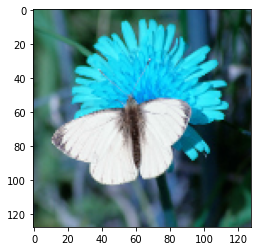

In [4]:
plt.imshow(data_img[0], cmap='gray')

In [5]:
def convolve2D(image, kernel, padding=0, strides=1):
    # Cross Correlation
    kernel = np.flipud(np.fliplr(kernel))

    # Gather Shapes of Kernel + Image + Padding
    xKernShape = kernel.shape[0]
    yKernShape = kernel.shape[1]
    xImgShape = image.shape[0]
    yImgShape = image.shape[1]

    # Shape of Output Convolution
    xOutput = int(((xImgShape - xKernShape + 2 * padding) / strides) + 1)
    yOutput = int(((yImgShape - yKernShape + 2 * padding) / strides) + 1)
    output = np.zeros((xOutput, yOutput))

    # Apply Equal Padding to All Sides
    if padding != 0:
        imagePadded = np.zeros((image.shape[0] + padding*2, image.shape[1] + padding*2))
        imagePadded[int(padding):int(-1 * padding), int(padding):int(-1 * padding)] = image
#         print(imagePadded)
    else:
        imagePadded = image

    # Iterate through image
    for y in range(image.shape[1]):
        # Exit Convolution
        if y > image.shape[1] - yKernShape:
            break
        # Only Convolve if y has gone down by the specified Strides
        if y % strides == 0:
            for x in range(image.shape[0]):
                # Go to next row once kernel is out of bounds
                if x > image.shape[0] - xKernShape:
                    break
                try:
                    # Only Convolve if x has moved by the specified Strides
                    if x % strides == 0:
                        output[x, y] = (kernel * imagePadded[x: x + xKernShape, y: y + yKernShape]).sum()
                except:
                    break

    return output

In [6]:
def sobel_detection(img):
    g_x = [[1, 0, -1]
          ,[2, 0, -2]
          ,[3, 0, -3]]
    
    g_y = [[1, 2, 3]
         ,[0, 0, 0]
         ,[-1, -2, -3]]
    
    h_x = convolve2D(img, g_x, padding=1)
    h_y = convolve2D(img, g_y, padding=1)
    
    sobel = (h_x**2 + h_y**2)**0.5 % 256
    
    return sobel

In [7]:
def rgb_sobel_detection(img):
    b = img[:, :, 0]
    g = img[:, :, 1]
    r = img[:, :, 2]
    
    sobel_b = sobel_detection(b)
#     print(sobel_b)
    sobel_g = sobel_detection(g)
#     print(sobel_g)
    sobel_r = sobel_detection(r)
#     print(sobel_r)
    
    sobel_img = np.dstack((sobel_b, sobel_g, sobel_r)).astype(int)
    return sobel_img

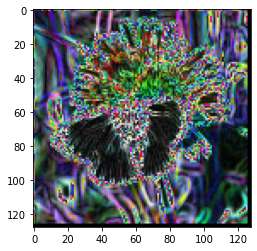

In [8]:
plt.imshow(rgb_sobel_detection(data_img[0]))

In [9]:
# def feature_extractor(dataset):
#     x_train = dataset
#     img_dataset = pd.DataFrame()
#     for image in range(x_train.shape[0]):
        
#         df = pd.DataFrame()
        
#         input_img = x_train[image, :,:,:]
#         img = input_img
   
#         # FEATURE 1 - Pixel values
#         pixel_values = img.reshape(-1)
#         df['Pixel_Value'] = pixel_values/255

#         # FEATURE 2 Sobel
#         edge_sobel = rgb_sobel_detection(img)
#         edge_sobel1 = edge_sobel.reshape(-1)
#         df['Sobel'] = edge_sobel1/255

#         img_dataset = img_dataset.append(df)
        
#     return img_dataset

In [10]:
def feature_extractor(dataset):
    img_dataset = []
    for img in dataset:
        # Sobel Feature
        edge_sobel = rgb_sobel_detection(img)
        edge_sobel1 = edge_sobel.reshape(-1)
        img_dataset.append(edge_sobel1/255)
        
    img_dataset = np.array(img_dataset)
    return img_dataset

In [11]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(data_label)
data_encoded = le.transform(data_label)

x_train, x_test, y_train, y_test = train_test_split(data_img, data_encoded, test_size=0.2)

In [12]:
image_features = feature_extractor(x_train)

from sklearn import svm
SVM_model = svm.SVC(decision_function_shape='ovo')
SVM_model.fit(image_features, y_train)

SVC(decision_function_shape='ovo')

In [13]:
test_features = feature_extractor(x_test)

test_prediction = SVM_model.predict(test_features)

In [14]:
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(y_test, test_prediction))

Accuracy =  0.34


<AxesSubplot:>

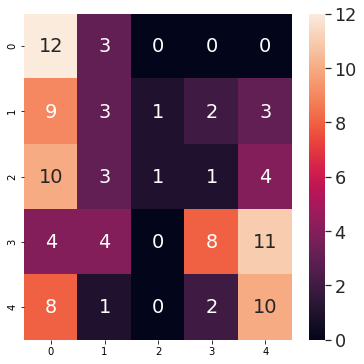

In [15]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, test_prediction)

fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, ax=ax)
